In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir
import pandas as pd 
from astropy.table import Table

## Resulting PTF QSO lightcurves from  S82

First, find how many quasars we have from this query, in  ../IPAC_output_tables/Ipac_PTF_lightcurves_QSO_S82.tbl 

In [2]:
# all lightcurves (may take a minute to read as the file has size of 82 MB ... )
lcs_qso = Table.read('../IPAC_output_tables/Ipac_PTF_lightcurves_QSO_S82.tbl', format='ipac')



In [5]:
type(lcs_qso)

astropy.table.table.Table

In [3]:
# This gives total number of epochs : 
len(lcs_qso)

159641

In [8]:
# Need to group by SDSS ra to get info about how many objects we have:
print('We have %d quasars to start with ' % len(np.unique(lcs_qso['ra'])))

We have 6471 quasars to start with 


## Remove empty files and those with less than 10 points 

Three equivalent ways of testing for the number of empty files.  Those files should be removed from the list of accepted QSO/ 

In [13]:
# Since I selected the objects from PTF asking them to have at least 
# ngoodobs > 10, there are definitely no objects with less than 10 epochs : 
np.sum(lcs_qso['ngoodobs'] < 10)

0

## Statistics on the raw  LC (before day-averaging)  

Group by ra : the SDSS ra, since ra_01 : the PTF ra , may differ from chip to chip,  just as oid .  For these quasars there seems to be only one edge-case ( number of unique ra is 6471, and oid : 6472, ra_01: 6480)

In [28]:
# drop some pesky 'masked' row... 
lcs_qso_new = lcs_qso[lcs_qso['ra'] != np.unique(lcs_qso['ra'])[-1]]




In [32]:
# group by ra to calculate stats on each object...
grouped_lcs = lcs_qso_new.group_by('ra')



I capitalize on what stats are **really** needed. I'm not making a Fig.1 for PTF. If needed in the future, I may worry about that, but for now, I'll get some simple-to-do stats  (per object-grouped group :  max(mjd) - min(mjd),  mean(mag), mean(err) ) .  Means are built-in as group-aggregates , and the max-min  statistic I'll try to implement as a function.  

Either way,  stats are not as needed as just making the master files  (delta_t, delta_mag, error),  and the PTF-SDSS matched catalogs, to use SDSS r-mag for magnitude cuts. 

In [67]:
# calculate some aggregate info...

# ra = grouped_lcs.groups.keys[0]
#http://docs.astropy.org/en/stable/table/operations.html 

# display first 10 rows of the first group
grouped_lcs.groups[0][:10]



cntr_01,dist_x,pang_x,ra_01,dec_01,obsmjd,mag_autocorr,magerr_auto,oid,ra,dec,fid,transient_flag,astrometricrms,nobs,ngoodobs,nbestobs,referencemag,referencemagerr,medianmag,bestmedianmag,meanmag,bestmeanmag,magrms,bestmagrms,sid,s_ra,s_dec,ptffield,ccdid,hmjd,nid,mag_auto,limitmag,absphotzp,fwhmsex,fwhm_image,qaflags,flags,photcalflag,goodflag
,arcsec,deg,degrees,degrees,days,mag,mag,,degrees,degrees,,,degrees,,,,mag,mag,mag,mag,mag,mag,mag,mag,,degrees,degrees,,,days,,mag,mag,mag,arcsec,pixels,,,"0=No, 1=Yes","0=No, 1=Yes"
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1211,0.0,180.0,0.049846,0.040389,56920.3323372,17.249,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21434266001679,0.049834,0.040392,2697,6,56920.3380872,1983,17.249,21.592,27.843,3.05,3.56,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56952.2524972,17.237,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21923244001705,0.049843,0.040389,2697,6,56952.2576672,2014,17.239,21.624,27.871,2.65,2.912,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56914.2943372,17.258,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21364525001402,0.049841,0.040379,2697,6,56914.3000172,1979,17.248,21.014,27.801,2.45,2.836,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56914.3413172,17.244,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21364555001390,0.04984,0.040393,2697,6,56914.3469972,1979,17.228,21.027,27.816,2.45,2.618,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56927.2768872,17.239,0.036,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21547909001793,0.049844,0.040393,2697,6,56927.2826572,1990,17.223,21.705,27.853,2.55,2.977,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56927.3321972,17.282,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21547958001377,0.049848,0.040385,2697,6,56927.3379672,1990,17.285,21.307,27.856,3.65,4.108,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56954.2361372,17.275,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21960345001818,0.049845,0.040391,2697,6,56954.2412072,2016,17.278,21.51,27.874,2.85,3.055,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56954.2640372,17.262,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21960367001850,0.049848,0.040389,2697,6,56954.2691172,2016,17.275,21.709,27.868,2.35,2.585,0,131072,0,1


 All the quick stats below : test on few objects... 

In [117]:

#n_groups = 2
test_group = grouped_lcs.groups[:2]
#test_agg_info = grouped_lcs.groups.keys[:2]
test_agg_info = test_group[['ra','dec', 'oid', 'magerr_auto','mag_autocorr']].groups.aggregate(np.mean)

def agg_func(array):
    'return max(array)-min(array)'
    return max(array) - min(array)

test_agg_info['mjd_span'] =  test_group['obsmjd'].groups.aggregate(agg_func)
test_agg_info['lc_length'] = test_group['ra'].groups.aggregate(np.count_nonzero)

# rename columns, since aggregate leaves the columns unchanged...
test_agg_info.rename_column('magerr_auto', 'avg_err')
test_agg_info.rename_column('mag_autocorr', 'avg_mag')

And do on all objects.... 

In [201]:
# And do on all objects.... 
raw_agg_info = grouped_lcs[['ra','dec', 'oid', 'magerr_auto','mag_autocorr']].groups.aggregate(np.mean)

def agg_func(array):
    'return max(array)-min(array)'
    return max(array) - min(array)

raw_agg_info['mjd_span'] =  grouped_lcs['obsmjd'].groups.aggregate(agg_func)
raw_agg_info['lc_length'] = grouped_lcs['ra'].groups.aggregate(np.count_nonzero)

# rename columns, since aggregate leaves the columns unchanged...
raw_agg_info.rename_column('magerr_auto', 'avg_err')
raw_agg_info.rename_column('mag_autocorr', 'avg_mag')
raw_agg_info.rename_column('ra', 'ra_sdss')
raw_agg_info.rename_column('dec', 'dec_sdss')



In [203]:
# Save that info as something that could be easily accessed to make PTF - SDSS matched catalog 

raw_agg_info.write('../data_products/PTF_qso_raw_agg_info.dat', format='ascii', overwrite='True')
    

(array([ 2942.,    28.,  1890.,    34.,   163.,   116.,   108.,   102.,
          372.,   715.]),
 array([    0.      ,   193.190252,   386.380504,   579.570756,
          772.761008,   965.95126 ,  1159.141512,  1352.331764,
         1545.522016,  1738.712268,  1931.90252 ]),
 <a list of 1 Patch objects>)

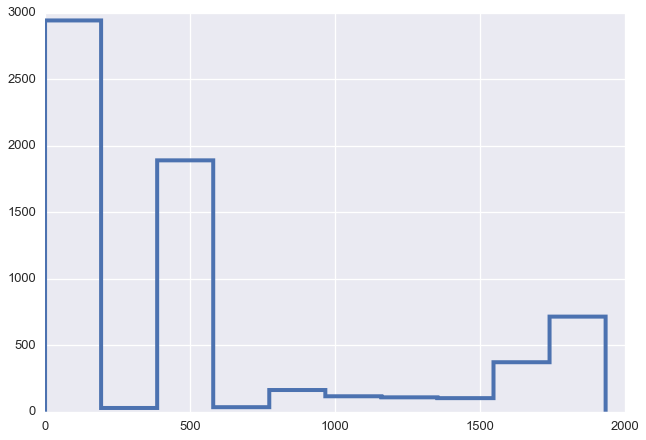

In [207]:
# Show some stats....

plt.hist(raw_agg_info['mjd_span'], histtype='step', lw=4)


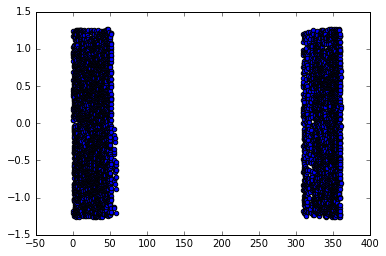

In [164]:
plt.scatter(agg_info['ra'], agg_info['dec'])


### Preprocessing : Day-averaged light curves : needs be RUN ONLY ONCE  to make them!

Make day-averaged lightcurves, save only if more than 10 observing days (points in the day-averaged light curve). 
Save MJD, avg_mag, error, N_obs that day. For our 6471 lightcurves it takes about 1.5 mins on my workstation. 

Test on a few lightcurves : 

In [145]:
# Input lightcurves are lcs_qso_new , and it is an AstroPy Table 
# Each lightcurve is most easily accessed as a grouped object  by 'ra' : 
# object_lc = grouped_lcs.groups[i] 
# 
object_lc = grouped_lcs.groups[0] 
mjd = np.array(object_lc['obsmjd'])
mags = np.array(object_lc['mag_autocorr'])
errs = np.array(object_lc['magerr_auto'])

days = np.unique([int(day) for day in mjd])

# store values for a given object... 
mjd_arr = np.zeros_like(days).astype(float)
avg_mags = np.zeros_like(days).astype(float)
err_weights = np.zeros_like(days).astype(float)  

for i in range(len(days)):
    day = days[i]
    int_mjd = np.require(mjd,int)       # forcing mjd array -> integers
    condition = (int_mjd == day)        # finding where int(mjd) = day

    w=1.0 / ( errs[condition] * errs[condition]) 
    avgmag = np.average(mags[condition], weights = w)       
    avg_mags[i] = avgmag
    error_weights = 1.0 / np.sqrt(np.sum(w))

    # increase error if too small 
    if error_weights < 0.02 : 
        error_weights = np.sqrt(error_weights**2.0 + 0.01**2.0)  
    err_weights[i] = error_weights

    mjd_arr[i] = np.mean(mjd[condition])
    
    

<Container object of 3 artists>

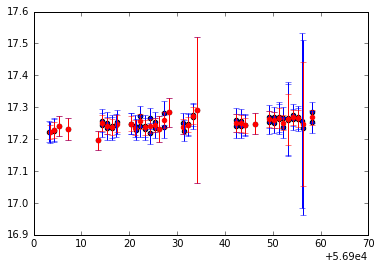

In [156]:
# Plot the original (blue) and the averaged lightcurve (red)...
plt.scatter(mjd,mags)
plt.errorbar(mjd,mags,errs, ls="None")
plt.scatter(mjd_arr, avg_mags, color='red')
plt.errorbar(mjd_arr, avg_mags, err_weights, color='red', ls='None')


In [157]:
len(grouped_lcs.groups.keys)



6470

Run on all 6470 lightcurves : 

In [160]:
from CRTS_paper_modules import update_progress


In [163]:
grouped_lcs.groups[0]


cntr_01,dist_x,pang_x,ra_01,dec_01,obsmjd,mag_autocorr,magerr_auto,oid,ra,dec,fid,transient_flag,astrometricrms,nobs,ngoodobs,nbestobs,referencemag,referencemagerr,medianmag,bestmedianmag,meanmag,bestmeanmag,magrms,bestmagrms,sid,s_ra,s_dec,ptffield,ccdid,hmjd,nid,mag_auto,limitmag,absphotzp,fwhmsex,fwhm_image,qaflags,flags,photcalflag,goodflag
,arcsec,deg,degrees,degrees,days,mag,mag,,degrees,degrees,,,degrees,,,,mag,mag,mag,mag,mag,mag,mag,mag,,degrees,degrees,,,days,,mag,mag,mag,arcsec,pixels,,,"0=No, 1=Yes","0=No, 1=Yes"
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1211,0.0,180.0,0.049846,0.040389,56920.3323372,17.249,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21434266001679,0.049834,0.040392,2697,6,56920.3380872,1983,17.249,21.592,27.843,3.05,3.56,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56952.2524972,17.237,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21923244001705,0.049843,0.040389,2697,6,56952.2576672,2014,17.239,21.624,27.871,2.65,2.912,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56914.2943372,17.258,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21364525001402,0.049841,0.040379,2697,6,56914.3000172,1979,17.248,21.014,27.801,2.45,2.836,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56914.3413172,17.244,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21364555001390,0.04984,0.040393,2697,6,56914.3469972,1979,17.228,21.027,27.816,2.45,2.618,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56927.2768872,17.239,0.036,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21547909001793,0.049844,0.040393,2697,6,56927.2826572,1990,17.223,21.705,27.853,2.55,2.977,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56927.3321972,17.282,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21547958001377,0.049848,0.040385,2697,6,56927.3379672,1990,17.285,21.307,27.856,3.65,4.108,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56954.2361372,17.275,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21960345001818,0.049845,0.040391,2697,6,56954.2412072,2016,17.278,21.51,27.874,2.85,3.055,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56954.2640372,17.262,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21960367001850,0.049848,0.040389,2697,6,56954.2691172,2016,17.275,21.709,27.868,2.35,2.585,0,131072,0,1


In [178]:
dir_out = '../proc_LC_PTF/qso/'
number_of_lightcurves = len(grouped_lcs.groups.keys)
keys = np.array(grouped_lcs.groups.keys)

for k in range(number_of_lightcurves):
    
    percent = 100*(k / number_of_lightcurves)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    
    object_lc = grouped_lcs.groups[k] 
    mjd = np.array(object_lc['obsmjd'])
    mags = np.array(object_lc['mag_autocorr'])
    errs = np.array(object_lc['magerr_auto'])

    days = np.unique([int(day) for day in mjd])

    # store values for a given object... 
    mjd_arr = np.zeros_like(days).astype(float)
    avg_mags = np.zeros_like(days).astype(float)
    err_weights = np.zeros_like(days).astype(float)  
    N_per_day = np.zeros_like(days).astype(float)
    
    for i in range(len(days)):
        day = days[i]
        int_mjd = np.require(mjd,int)       # forcing mjd array -> integers
        condition = (int_mjd == day)        # finding where int(mjd) = day
        
        # number of obs in that night 
        N_per_day[i] = float(len(mags[condition]))
        
        w=1.0 / ( errs[condition] * errs[condition]) 
        avgmag = np.average(mags[condition], weights = w)       
        avg_mags[i] = avgmag
        error_weights = 1.0 / np.sqrt(np.sum(w))

        # increase error if too small 
        if error_weights < 0.02 : 
            error_weights = np.sqrt(error_weights**2.0 + 0.01**2.0)  
        err_weights[i] = error_weights

        mjd_arr[i] = np.mean(mjd[condition])

      
    # Save the output... 
    # Once per lightcurve 
    # ONLY IF THERE IS MORE THAN 10 OBS ! 
    
    if( len(mjd_arr) >  10 ) :
        object_name = str(keys[k][0])
        name_out = dir_out  + object_name +'.txt'
        np.savetxt(name_out, np.column_stack((mjd_arr,avg_mags, err_weights, N_per_day)),fmt='%11.4f')
        
print('finished')

[######### ] 99.00%

ra_sdss,dec_sdss,oid,avg_err,avg_mag,mjd_span,lc_length
degrees,degrees,,mag,mag,days,degrees
float64,float64,float64,float64,float64,float64,int64
0.049846,0.040389,2.69710600005e+13,0.0484603174603,17.2498571429,54.92261,63
0.061789,-1.175205,2.59220600024e+13,0.128666666667,19.9896666667,1056.22068,3
0.074522,0.436856,2.69710600019e+13,0.108683333333,20.1102666667,54.92261,60
0.178728,0.927669,2.25921000005e+14,0.032,18.2735,0.0390999999945,2
0.193409,1.239113,2.69720000006e+13,0.1502,20.2062,1863.83628,5
0.214843,0.200738,2.25922000002e+14,0.1259,20.2657,70.9601,20
0.225083,0.917532,2.69710600037e+13,0.115596774194,20.2757741935,54.92261,62
0.22903,1.028718,2.69720600029e+13,0.1,19.5462,1891.8302,5


## Statistics on the day-averaged LC

Here I add to the raw LC statistics (agg_info), the statistics on day-averaged lightcurves.
Thus necessarily I select only those rows that correspond to objects 
that had a day-averaged lightcurve longer than 10 days, so that they made it to 
proc_LC_PTF/  directory . 

avg_err :  average of raw PTF errors over all epochs

avg_mag : average of raw PTF magnitudes over all epochs

mjd_span : min(mjd) - max(mjd), before day-averaging 
 
lc_length : number of epochs before day-averaging 

In [285]:
from astropy.table import Table

# Read in the previously saved stats on aggregate data for all objects 
address = '../data_products/PTF_qso_raw_agg_info.dat' 
raw_agg_info = Table.read(address,format='ascii' )




In [286]:
ra_info = np.array(agg_info['ra_sdss']).astype(str)

dir_in = '../proc_LC_PTF/qso/'
files = np.array(listdir(dir_in))
ra_files = np.array([name[:-4] for name in files])

# Choose only those PTF aggregate info about lightcurves that 
# during day-averaging were found to have at least day-averaged 10 epochs  (10 separate days of observations)

raw_agg_info_select = raw_agg_info[np.in1d(ra_info, ra_files)]



In [287]:
print('Only %d quasars out of %d have more than 10 days of obs '%(len(raw_agg_info_select),len(raw_agg_info)))
      

Only 2753 quasars out of 6470 have more than 10 days of obs 


In [277]:
# the files below are only for those quasars that have
# more than 10 observations per day... 
# agg_info.write('../data_products/PTF_qso_aggregate_info.dat', format='ascii', overwrite='True')



ra_files = np.array([name[:-4] for name in files])
# make new columns:
#avg_day_err :  the average of processed lightcurves errors 
#avg_day_mag : the average of processed lightcurves magnitudes 
# 
# make an array for storing total timespan of obs per object, 
# as well as the total number of nights per object
proc_mjd_span = np.zeros_like(files, dtype=float) # store what was the total  timespan of observations per object
proc_lc_length=np.zeros_like(files, dtype=float) # number of points in the lightcurve - equal to the number of obs nights
avg_N_per_day = np.zeros_like(files, dtype=float)
avg_day_mag = np.zeros_like(files, dtype=float)
avg_day_err = np.zeros_like(files, dtype=float)
avg_mjd_diff= np.zeros_like(files, dtype=float)

k = 0
total = float(len(files))

for i in range(len(files)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    # choose processed lightcurves according to 
    # order of the aggregate info 
    # then rows will match . 
    
    ra_sdss = str(agg_info_select['ra_sdss'][i])
    address=dir_in+files[ra_files == ra_sdss][0]
    
    data=np.loadtxt(address) 
    proc_lc_length[i] = sum(1 for line in open(address))
    avg_day_mag[i] = np.mean(data[:,1])
    avg_day_err[i] = np.mean(data[:,2])
    avg_N_per_day[i] = np.mean(data[:,3])
    proc_mjd_span[i] = data[-1,0]-data[0,0]  # gives number of days between first and last obs
    
        #mjd_diff = np.zeros(len(data[:,0]))
    #for j in range(len(data)-1):
    #    mjd_diff[j] = data[j+1,0] - data[j,0]
    #avg_mjd_diff[i] = np.mean(mjd_diff)     # avg span between obs in MJD    
    
keys = ['ra_files', 'proc_mjd_span', 'proc_lc_length', 'avg_N_per_day', 'avg_day_mag', 'avg_day_err']
values = [np.array(ra_files).astype(float), proc_mjd_span,proc_lc_length,avg_N_per_day,avg_mag_ttl,avg_err_ttl]


stats_proc_lc ={}
for key, value in zip(keys, values):
    stats_proc_lc[key] = value
    
    
    

[######### ] 99.00%

In [278]:
# make an Astropy table from these stats, and add it to agg_info_selected 

stats = Table(stats_proc_lc)
stats[:6]



avg_day_mag,proc_mjd_span,ra_files,avg_day_err,avg_N_per_day,proc_lc_length
float64,float64,float64,float64,float64,float64
17.2495,54.8939,0.049846,0.0389971428571,1.8,35.0
20.0987352941,54.8939,0.074522,0.0838117647059,1.76470588235,34.0
20.2590382353,54.8939,0.225083,0.0896970588235,1.82352941176,34.0
19.4490371429,1122.9245,0.331011,0.0621857142857,1.88571428571,35.0
20.4550266667,54.8939,0.91298,0.117276666667,1.6,30.0
18.9295514286,1122.9245,1.148971,0.0567,1.91428571429,35.0


In [279]:
stats.rename_column('ra_files', 'ra_sdss')

In [280]:
#http://docs.astropy.org/en/stable/api/astropy.table.join.html
# beautiful examples 
# https://star.herts.ac.uk/~gb/python/14-astropy-tables.html  
from astropy.table import join
agg_info_merged = join(left=raw_agg_info_select, right = stats, keys='ra_sdss')


In [284]:
#  Save the combined catalog, with both raw lightcurve aggregates, and processed lightcurve aggregates 
# this is the master catalog combining all the PTF information about quasars in one place 


agg_info_merged.write('../data_products/PTF_qso_raw_and_proc_combined_agg_info_2753.dat', format='ascii', overwrite='True')



In [283]:
agg_info_merged.colnames



['ra_sdss',
 'dec_sdss',
 'oid',
 'avg_err',
 'avg_mag',
 'mjd_span',
 'lc_length',
 'avg_day_mag',
 'proc_mjd_span',
 'avg_day_err',
 'avg_N_per_day',
 'proc_lc_length']

## Compare before and after day-averaging: plot error and mag distribution 

array([ 0.23379035,  0.61212027,  0.40945688,  0.19647036,  0.72936668,
        0.87329424,  0.97189702,  0.8041134 ,  0.50850535,  0.69234322])

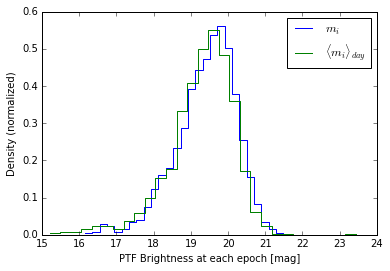

In [187]:
m = (stats_proc_lc['mag']>15)*(stats_proc_lc['mag']<22)
#plt.hist(mag_list[m])

#sns.set_context('talk')
fig,ax = plt.subplots(1,1)
nbins=30
# Calculate the histogram1 : individual epoch brightness measurements 
hist1, bin_edges = np.histogram(stats_proc_lc['mag'][m], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : day-averaged brightness measurements 
hist2, bin_edges = np.histogram(stats_after['avg_mag'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label=r'$m_{i}$')
ax.plot(bin_centres2, hist2, ls = 'steps', label=r'$\langle m_{i}\rangle_{day}$')
plt.legend(loc='best')
ax.set_ylabel('Density (normalized)')
ax.set_xlabel('PTF Brightness at each epoch [mag]')

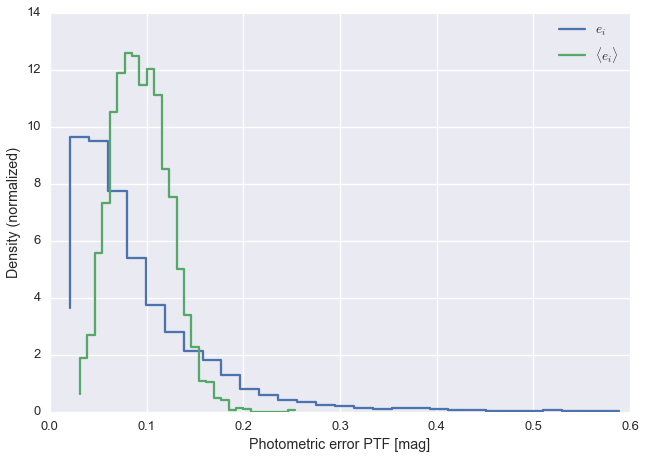

In [198]:
#import seaborn as sns
#sns.set_context('talk')
fig,ax = plt.subplots(1,1)
nbins=30
# Calculate the histogram1 : new day-averages
hist1, bin_edges = np.histogram(stats_proc_lc['err'][stats_proc_lc['err']<0.6], bins=nbins, density=True)
bin_centres1 = (bin_edges[:-1] + bin_edges[1:])/2

# Calculate the histogram2 : old day-averages
hist2, bin_edges = np.histogram(stats_proc_lc['avg_err'], bins=nbins, density=True)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2

ax.plot(bin_centres1, hist1, ls = 'steps', label=r'$ e_{i} $')
ax.plot(bin_centres2, hist2, ls = 'steps', label=r'$\langle e_{i} \rangle $')
plt.legend(loc='best')
ax.set_ylabel('Density (normalized)')
ax.set_xlabel('Photometric error PTF [mag]')

## Compare PTF r mag  with SDSS r mag  for QSO

In [197]:
import CRTS_paper_modules as mod
cols1, qso_cat = mod.get_qso_catalog() 


Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS


In [210]:
address = '../data_products/PTF_qso_aggregate_info.dat'
ptf_agg_info = Table.read(address,format='ascii' )

In [217]:
len(ptf_agg_info)

6470

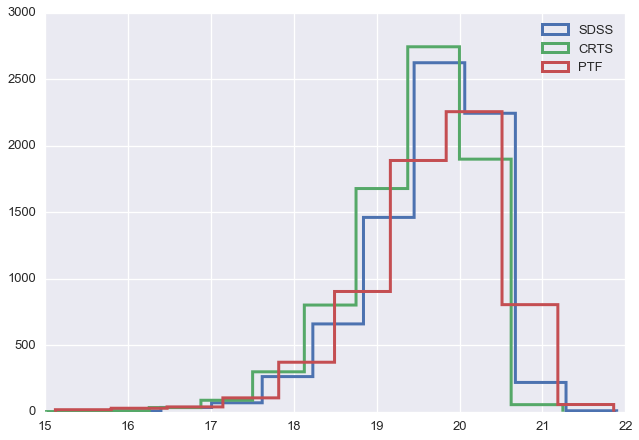

In [215]:

# SDSS r-mag 
r = np.array(qso_cat['r']).astype(float)
m = (r > 15)*(r<22)
plt.hist(r[m], histtype='step', lw=3, label='SDSS')

# CRTS white light 
avg_mag = np.array(qso_cat['CRTS_avg_m']).astype(float)
plt.hist(avg_mag,histtype='step', lw=3, label='CRTS')

#PTF r mag 
ptf_mag = np.array(ptf_agg_info['avg_mag'])
m = (ptf_mag > 15)*(ptf_mag<22)

plt.hist(ptf_mag[m],histtype='step', lw=3, label='PTF')
plt.legend()

## Make Fig.1 : statistical properties of those QSO I use in my analysis 

In [222]:
stats_proc_lc.keys()

dict_keys(['avg_err', 'avg_N_day', 'err', 'avg_mag', 'mag', 'timespan_obs', 'lc_length', 'avg_mjd_diff'])

CRTS Quasars: sample of 7601


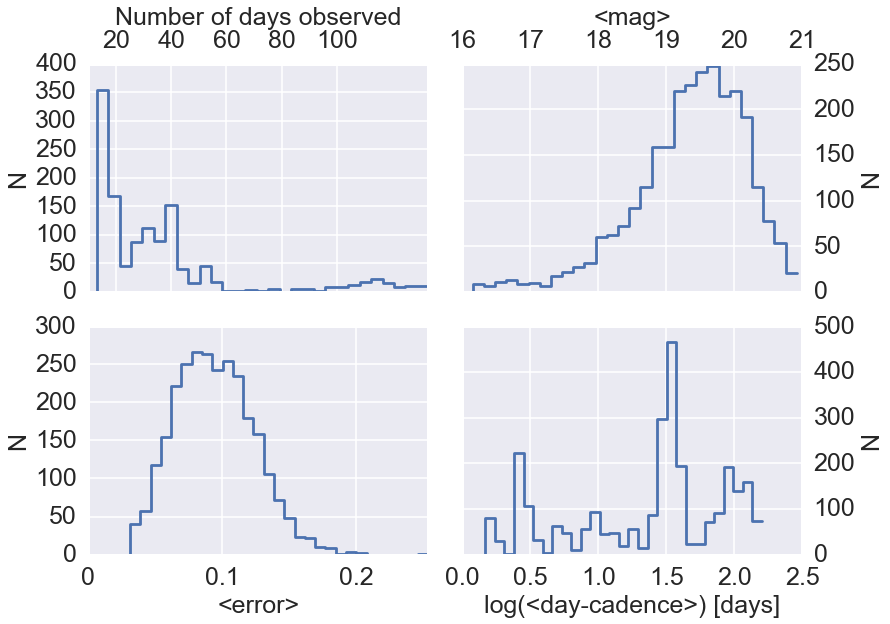

In [223]:
%matplotlib inline

import seaborn as sns
sns.set_context('poster')
from matplotlib import rcParams
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25

fig = plt.figure()
fig.subplots_adjust(hspace=0.15)
fig.subplots_adjust(wspace=0.1)
print('CRTS Quasars: sample of 7601')
# Set number of histogram bins 
nbins = 30


# Panel 1 
ax1 = fig.add_subplot(221)
ax1.set_ylabel('N')
ax1.set_xlabel('Number of days observed')
ax1.set_xticks([0,20,40,60,80,100])
ax1.set_xticklabels(['0','20','40','60','80','100'])

ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
hist2, bin_edges = np.histogram(stats_proc_lc['lc_length'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0
ax1.set_xlim(xmin = 10, xmax = max(bin_centres2))
ax1.plot(bin_centres2, hist2, ls = 'steps')

# Panel 2 
ax2 = fig.add_subplot(222)
ax2.set_ylabel('N')
ax2.set_xlabel('<mag>')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
a = stats_proc_lc['avg_mag']
m = (a > 16) * (a < 21)
hist2, bin_edges = np.histogram(a[m], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0  # start at 0 

ax2.plot(bin_centres2, hist2, ls = 'steps')

# Panel 3 
ax3 = fig.add_subplot(223)
ax3.set_ylabel('N')
ax3.set_xlabel('<error>')
ax3.set_xticks([0,0.1,0.2,0.3,0.4])
ax3.set_xticklabels(['0','0.1','0.2','0.3','0.4'])

hist2, bin_edges = np.histogram(stats_proc_lc['avg_err'], bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
ax3.set_xlim(xmin = 0, xmax = max(bin_centres2))
hist2[0]=0

ax3.plot(bin_centres2, hist2, ls = 'steps')

# Panel 4 
ax4 = fig.add_subplot(224)
ax4.set_ylabel('N')
ax4.set_xlabel('log(<day-cadence>) [days]')  # time between consecutive observations
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

hist2, bin_edges = np.histogram(np.log10(stats_proc_lc['avg_mjd_diff']), bins=nbins, density=False)
bin_centres2 = (bin_edges[:-1] + bin_edges[1:])/2
hist2[0]=0

ax4.plot(bin_centres2, hist2, ls = 'steps')


# Save

plt.savefig('../data_products/PTF_Fig_1_QSO_avg_stats_four_panels.png')
